In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import datetime
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'pandas'

In [2]:
data = pd.read_excel('XXX')
project=data
data

NameError: name 'pd' is not defined

In [50]:
projects = ['p50_david_dietz_2020','p50_hao_chen_2020','p50_hao_chen_2020_rnaseq','p50_paul_meyer_2020',
            'u01_olivier_george_cocaine', 'u01_olivier_george_oxycodone', 'u01_olivier_george_scrub',
            'u01_peter_kalivas_italy', 'u01_peter_kalivas_us', 'u01_suzanne_mitchell', 'u01_tom_jhou' ]
def runQuery(query):
    connection = psycopg2.connect(database = "PalmerLab_Datasets",
                                  user = "postgres",
                                  password = "palmerlab-amapostgres",
                                  host = "palmerlab-main-database-c2021-08-02.c6sgfwysomht.us-west-2.rds.amazonaws.com",
                                  port = '5432')
    cursor = connection.cursor()
    if "SELECT" in query:
        table = pd.read_sql(query, con = connection)
    elif "UPDATE" in query:
        cursor.execute(query)
        print(query)
        connection.commit()
    elif "DELETE" in query:
        cursor.execute(query)
        print(query)
        connection.commit()
    else:
        return None
    if connection:
        cursor.close()
        connection.close()
        if "SELECT" in query:
            return table
        else:
            return
# #change project here
current_project = 'u01_peter_kalivas_italy.wfu_master'
wfu = runQuery("SELECT * FROM " + current_project)
wfu
# wfu_master['project_name'].value_counts()

# wfu_master['cohort'].value_counts().sort_index()


,cohort,sires,dames,labanimalid,accessid,sex,rfid,dob,dow,shipmentdate,litternumber,littersize,coatcolor,earpunch,rack,shipmentbox,shipmentage,weanage,comments,resolution
0,C01,72789_1,73020_2,IT037,73787_1,M,933000320045620,2018-12-28,2019-01-18,2019-02-04,7.0,10.0,ALBINO,LC,D-B2,3.0,38.0,21.0,Original shipment date 2019-01-29 (held 1 week...,None
1,C03,73875_1,73687_2,IT101,74490_1,M,933000320047210,2019-06-30,2019-07-22,2019-08-19,4.0,14.0,ALBINO,LM,D-F6,2.0,50.0,22.0,Original shipment 2019-08-05 (held 2 weeks due...,None
2,C02,73399_2,73378_1,ITALY6,74161_1,M,933000320046951,2019-04-04,2019-04-25,2019-05-06,5.0,5.0,BLACK,RM,D-I2,7.0,32.0,21.0,Scrub,None
3,C10,76112_1,76062_2,IT397,77258_5,M,933000320188609,2021-01-06,2021-01-26,2021-02-08,4.0,13.0,BLACKHOOD,LC,E-A5,2.0,33.0,20.0,NA,NA
4,C02,73184_1,73136_2,ITALY2,74162_1,M,933000320046972,2019-04-04,2019-04-25,2019-05-06,5.0,7.0,BLACK,RT,D-I1,7.0,32.0,21.0,Scrub,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,C14,76847_1,77217_2,IT560,78585_2,F,933000320500144,2021-08-26,2021-09-16,2021-09-24,6.0,9.0,BLACK,RM,E-H4,8.0,29.0,21.0,NA,NA
651,C14,77197_1,76729_4,IT547,78557_2,F,933000320500289,2021-08-22,2021-09-13,2021-09-24,5.0,9.0,BLACKHOOD,LM,E-H1,7.0,33.0,22.0,NA,NA
652,C16,77406_1,77668_2,IT574,79308_1,M,933000320525438,2021-12-28,2022-01-18,2022-02-07,7.0,5.0,BLACKHOOD,RC,E-F4,2.0,41.0,21.0,NA,NA
653,C16,77407_1,77381_2,IT579,79284_4,F,933000320525440,2021-12-29,2022-01-19,2022-02-07,9.0,12.0,BROWN,LC,E-G7,6.0,40.0,21.0,NA,NA


In [9]:
def fixColumns(columns):
    for i in range(len(columns)):
        columns[i] = columns[i].lower().replace(" ", "")
        if "sir" in columns[i] or "father" in columns[i]:
            columns[i] = "sires"
        elif "dam" in columns[i] or "mother" in columns[i]:
            columns[i] = "dames"
        elif "animal" in columns[i] and "id" in columns[i]:
            columns[i] = "labanimalid"
        elif "access" in columns[i] and "id" in columns[i]:
            columns[i] = "accessid"
        elif "sex" in columns[i]:
            columns[i] = "sex"
        elif "rfid" in columns[i] or "ponder" in columns[i]:
            columns[i] = "rfid"
        elif ("d" in columns[i] and "o" in columns[i] and "b" in columns[i]) or "birth" in columns[i]:
            columns[i] = "dob"
        elif ("d" in columns[i] and "o" in columns[i] and "w" in columns[i]) or ("wean" in columns[i] and "date" in columns[i]):
            columns[i] = "dow"
        elif "ship" in columns[i] and "date" in columns[i]:
            columns[i] = "shipmentdate"
        elif "litter" in columns[i] and ("#" in columns[i] or "num" in columns[i]):
            columns[i] = "litternumber"
        elif "ship" in columns[i] and "box" in columns[i]:
            columns[i] = "shipmentbox"
        elif "comment" in columns[i] or "note" in columns[i]:
            columns[i] = "comments"
    return columns


In [10]:
def checkDupCols(data):
    for col in data.columns:
        if ".1" in col:
            data[col] = data[col].astype(str)
            data[col.replace(".1", "")] = data[col.replace(".1", "")].astype(str)
            data[col] = [val.replace(".0", "") for val in data[col]]
            data[col.replace(".1", "")] = [val.replace(".0", "") for val in data[col].replace(".1", "")]
            if list(data[col] == data[col.replace(".1", "")]).count(True) != len(data[col]):
                print("Transponder ID Mismatch found")
                print(data[col])
                print(data[col.replace(".1", "")])
            del data[col]
    return data

In [11]:
#Specific Errors

def date_error(data):
    #Meyer2020 Shipping Sheet #7
    a = (data['dob'] == '4/21/20221')
    data.loc[a,'dob'] = '4/21/2021'
    return data

def comment_error(data):
    #Meyer2020 Shipping Sheet #7
    #data["comments"] = "NA"
    if 'unnamed:18' in data.columns:
        data.loc[data['unnamed:18'] == 'DOUBLE PULLS','unnamed:18'] = np.nan
        data.loc[(data['rfid'] == 'AA1DCD6794'),'comments'] = "DOUBLE PULLS"
        data = data.drop(columns = ['unnamed:18'])
    return data
    
def column_error(data):
    #Meyer2020 Shipping sheet #7
    if '124rats' in data.columns:
        data = data.drop(columns=['124rats'])
    return data

def error_rows(data):
    #Meyer2020 Shipping sheet #7
    #Meyer2020 Shipping sheet #8
    if 'unnamed:5' in data.columns:
        print("Difference between unnamed:5 and rfid")
        display(data.loc[~(data['unnamed:5'] == data['rfid'])])
        print("unnamed:5 value counts")
        display(data['unnamed:5'].value_counts().to_string())
        print("Dropped unnamed:5")
        data = data.drop(columns = ['unnamed:5'])
    return data
        
def error_rfids(data):
    data['rfid'] = data['rfid'].str.upper()

In [41]:
#calculate the weanage and shipment age
def addAge(data, col_name):
    data['dob'] = pd.to_datetime(data['dob'],errors='coerce')
    data['dow'] = pd.to_datetime(data['dow'],errors='coerce')
    data['shipmentdate'] = pd.to_datetime(data['shipmentdate'],errors='coerce')

    if "ship" in col_name:
        i_date = list(data.columns).index("shipmentdate")
    elif "wean" in col_name:
        i_date = list(data.columns).index("dow")
    else:
        print("Invalid col_name provided")
        return None
    values = []
    for index, row in data.iterrows():
        i_dob = list(data.columns).index("dob")
        # Want it to be datetime.date not datetime.datetime
        if not isinstance(data.iloc[index, i_dob], datetime.datetime):
            data.iloc[index, i_dob] = data.iloc[index, i_dob].date()
        if not isinstance(data.iloc[index, i_date], datetime.datetime):
            data.iloc[index, i_date] = data.iloc[index, i_date].date()
        values.append((data.iloc[index, i_date] - data.iloc[index, i_dob]).days)
    return values

# weanage=addAge(data, 'weanage')
# data['weanage']=weanage
# data

In [42]:
#change transponder ID into rfid
def rfid_column():
    if "Transponder ID" in data.columns:
        i = list(data.columns).index("Transponder ID")
        for index, row in data.iterrows():
            data.iloc[index, i] = data.iloc[index, i].upper()
            if data.iloc[index, i][:2] != "AA":
                data.iloc[index, i] = "AA" + data.iloc[index, i]
        checkDupCols(data)
        data.columns = fixColumns(list(data.columns))
#rfid_column()

In [43]:
# Check if data columns look correct
#print("Data columns:", list(data.columns))
#remove NA columns
def drop_na(data):
    list1 = data.columns
    #print(list1)
    data = data.dropna(axis=1, how='all')
    list2 = data.columns
    #print(list2)
    diff = list(set(list1).difference(list2))
    if len(diff) >= 1:
        print("\nData columns dropped due to all NA:", diff)
    return data


In [13]:
def rfid_in_wfu(data):
    data["rfid"] = data["rfid"].astype(str)
    wfu_master_rfids = list(wfu_master["rfid"])
    data_rfids = list(data["rfid"])
    duplicate_rfids = list(set(wfu_master_rfids).intersection(set(data_rfids)))
    print(len(duplicate_rfids), "rfids already in WFU_master, out of", len(data_rfids))
#     print(duplicate_rfids)
    fix = list(set(data_rfids) - set(wfu_master_rfids))


In [29]:
def new_columns(data):
    if True:
        # Making wfu_master and data have same columns
        cohort = "".join(filter(str.isdigit, project))
        if len(cohort) == 1:
            cohort = "0" + cohort
        data["cohort"] = "C" + cohort
        data["shipmentage"] = addAge(data, "shipmentage")
        data["weanage"] = addAge(data, "weanage")
        data["comments"] = "NA"
        data["resolution"] = "NA"
        #data = data[columns_wfu]
        for index, row in data.iterrows():
            for i in range(len(row)):
                if isinstance(data.iloc[index, i], datetime.date):
                    if isinstance(data.iloc[index, i], type(pd.NaT)):
                        data.iloc[index, i] = None
                    else:
                        data.iloc[index, i] = data.iloc[index, i].strftime("%Y/%m/%d")

# new_columns(data)


In [30]:
def column_qc():
    print("\n\nColumn headers for: "+ current_project)
    for column in data.columns:
        print(column)
    common_headers = ['cohort','sires','dames','labanimalid','accessid','sex','rfid','dob','dow','shipmentdate',
                      'litternumber','littersize','coatcolor','earpunch','rack','shipmentbox','shipmentage','weanage',
                      'comments','resolution']
    #find any odd column headers
    for column in data.columns:
        if column not in common_headers:
            print("\nNon uniform column headers:")
            print(column)
    for column in common_headers:
        if column not in data.columns:
            print("\nMissing uniform column header:")
            print(column)


In [31]:
# wfu_master
sheet="XXX"

In [32]:

def cohorts(data):
    print("\nNumber of cohorts for " + sheet + ":")
    display(data['cohort'].value_counts().sort_index())
    print("\nCohort for " + current_project +", " " and the number of subjects:")
    display(wfu_master['cohort'].value_counts().sort_index())
    
# cohorts(data)

In [33]:
#count the number of sires and dames in each cohort
#count how many of those sires and dames are unique meaning that multiple sires and dames had more than one child
#check how many parent pairs there are
#Check how many parent pairs are present in multiple cohorts
#check if there is an rfid labeled as both a sire and a dame
#check for missing parents
def qc_pedigree(data):
    sires = list(data["sires"])
    dames = list(data["dames"])
    
    data = data.sort_values(["cohort", "labanimalid"])

#     Printing number of mothers and fathers per cohort
    unique_sires = []
    unique_dames = []
    for cohort in np.unique(data["cohort"]):
        subset = data[data["cohort"] == cohort]
        sires = list(subset["sires"])
        dames = list(subset["dames"])
        unique_sires.append(len(set(sires)))
        unique_dames.append(len(set(dames)))
        print(cohort, "sires", "unique", len(set(sires)))
        print(cohort, "dames", "unique", len(set(dames)))


#     Checking sibling numbers
    parents_dict = {}
    parents_litter_birth = {}
    dob = []
    litter = []
    parents_df = pd.DataFrame()
    for index, row in data.iterrows():
        parents = (row["sires"], row["dames"])
        
        if parents in parents_dict.keys():
            parents_dict[parents].append(row["rfid"])
            parents_litter_birth[parents].append(row["dob"])
        else:
            dob.append(row['dob'])
            litter.append(row['littersize'])
            parents_dict[parents] = [row["rfid"]]
            parents_litter_birth[parents] = [row["dob"]]
            parents_df = parents_df.append({'sires':row["sires"],'dames':row["dames"]},ignore_index = True)
    print("\nparent pairs",len(parents_dict.keys()), '\n')
    siblings = []
    for parents in parents_dict.keys():
        #print(parents, len(parents_dict[parents]))#, parents_dict[parents])
        siblings.append(len(parents_dict[parents]))
        cohorts = []
        for rfid in parents_dict[parents]:
            subset = data[data["rfid"] == rfid]
            subset.index = range(subset.shape[0])
            i_cohort = list(subset.columns).index("cohort")
            cohorts.append(subset.iloc[0, i_cohort])
        cohorts = list(np.unique(cohorts))
        if len(cohorts) != 1:
            print("parent pair across multiple cohorts found", cohorts)
    parents_df['siblings'] = siblings
    parents_df['dob'] = dob
    parents_df['litter_size'] = litter
#     parents_df['removed_litter'] = parents_df['litter_size'] - parents_df['siblings']
    

        
    #Check if there are any matching ids between sires and dames
    overlap = set(dames).intersection(set(sires))
    if len(list(overlap)) > 0:
        print("\nError: listed as dame and sire", list(overlap))
    elif len(list(overlap)) == 0:
        print('\nNo rfids labeled as both a sire and a dame')
    mislabeled_df = pd.DataFrame()
    unique_sires = data.sires.unique()
    unique_dames = data.dames.unique()
    mislabeled = [x for x in unique_sires if x in unique_dames]
    if len(overlap) > 0:
        mislabeled_nan_sires = data[data['sires'].isnull()]
        mislabeled_nan_dames = data[data['dames'].isnull()]
        mislabeled_nan = pd.concat([mislabeled_nan_sires,mislabeled_nan_dames]).drop_duplicates().reset_index(drop=True)
        if len(mislabeled_nan.index) > 0:
            print('\nMissing Sires/Dames for ' + current_project)
            display(mislabeled_nan)
        for rfid in mislabeled:
            mislabeled_df.append(data.loc[data['sires'] == rfid])
            mislabeled_df.append(data.loc[data['dames'] == rfid])
        if len(mislabeled_df.dropna().index) > 0:
            print('Mislabeled Sires/Dames')
            display(mislabeled_df.dropna())
        

    df_missing_sires = data[data.sires == 'None']
    df_missing_dames = data[data.dames == 'None']
    df_missing = pd.concat([df_missing_sires,df_missing_dames]).drop_duplicates().reset_index(drop=True)
    if len(df_missing) > 0:
        print('\nMissing Parents:')
        display(df_missing)
    else:
        print('\nNo missing parents')

# qc_pedigree(data)


In [19]:
def birth_range():
    date_min = min(data['dob'])
    date_max = max(data['dob'])
    date_range = date_max.date() - date_min.date()
    print('\nDOB range(days):', date_range.days)
    
# birth_range()
# min(data['dob'])
# max(data['dob'])

In [20]:
def wean_range():
    date_min = min(data['dow'])
    date_max = max(data['dow'])
    date_range = date_max - date_min
    print('\nDOW range(days):', date_range.days)

In [21]:
# Fixing coatcolor in sample_metadata
def coat_color(data):
    toFix = []
    metadata = data
    print(" Coat Colors:")
    display(data['coatcolor'].value_counts().to_frame())

    # metadata = select_wfu_master("u01_olivier_george_oxycodone")
    i_coatcolor = list(metadata.columns).index("coatcolor")
    for index, row in metadata.iterrows():
        coatcolor = data.iloc[index, i_coatcolor]
        if coatcolor == "BLK HOOD":
            coatcolor = "BLACKHOOD"
        elif coatcolor == "BRN HOOD":
            coatcolor = "BROWNHOOD"
        elif coatcolor == "BEN HOOD":
            coatcolor = "BROWNHOOD"
        elif coatcolor == "ALIBINO":
            coatcolor = "ALBINO"
#         coatcolor = coatcolor.replace(" ", "")
        if coatcolor != metadata.iloc[index, i_coatcolor]:
            toFix.append(index)
            metadata.iloc[index, i_coatcolor] = coatcolor
    metadata = metadata.iloc[toFix, :]
    metadata.index = range(metadata.shape[0])
    print("\nAfter Coat Color Normalization:")
    display(data['coatcolor'].value_counts().to_frame())

coat_color(data) 
    if len(metadata.index) > 0:
        print("Need to normalize following rows for coat color:")
        display(metadata)
wfu_master

 Coat Colors:


KeyError: 'coatcolor'

In [22]:
def qc_rfid(rfid, prefix, length):
    # Checking if prefix is present
    if rfid[:len(prefix)] != prefix:
        return False
    # Checking is rfid is correct length
    elif len(rfid) != length:
        return False
    return True
def check_rfid():
    #Check to make sure rfid for the project contains the correct naming convention
    project_metadata = pd.read_csv("project_metadata - project_metadata (1).csv", dtype = str)
    i_convention = list(project_metadata.columns).index("rfid_convention")
    subset = project_metadata[project_metadata["project_name"] == 'u01_peter_kalivas_italy']
    subset.index = range(subset.shape[0])
    convention_list = subset.iloc[0, i_convention]
    convention_list = convention_list.split(";")
    for i in range(len(convention_list)):
        convention_list[i] = convention_list[i].replace("(", "").replace(")", "").split(",")
    for rfid in data["rfid"]:#data needs to be combination of all projec
        passed = False
        for convention in convention_list:
            prefix = convention[0]
            length = int(convention[1])
            passed = passed + qc_rfid(rfid, prefix, length)
        if not passed:
            print('RFID errors:')
            print(rfid)#, project)
            display(data.loc[data['rfid']== rfid])
         
        
     


    
# check_rfid()




In [23]:
# data['siblings'] = np.nan
def siblings(data):
    data['siblings'] = np.nan 
    df = data.groupby(['dob','sires','dames'])['siblings'].count().reset_index()
    for index,row in df.iterrows():
        data.loc[(data["dob"] == row['dob']) & (data["sires"] == row['sires']) & (data['dames'] == row['dames']), "siblings"] = row['siblings']
    print("\nSibling value counts:")
    print("\n", data.siblings.value_counts().to_string())
    for index,row in data.iterrows():
        if row['siblings'] > 2:
            print("More than 2 siblings:\n")
            print(data.loc[[index]])
    return data

# siblings(data)




In [25]:
def graph_columns():
    graph_columns = ['sex','dob','dow','shipmentage','coatcolor','weanage']#,'littersize','litternumber']
    for col in graph_columns:
        plt.title(col)
        plt.xlabel('value')
        plt.ylabel('count')
        plt.xticks(rotation = 40)
        plt.hist(data[col].dropna())
        plt.show() 

# graph_columns()

0 rfids already in WFU_master, out of 60


Column headers for: u01_peter_kalivas_italy.wfu_master
dames
sires
accessid
labanimalid
sex
rfid
unnamed:6
dob
dow
shipmentdate
litternumber
littersize
coatcolor
earpunch
rack
shipmentbox
comments
cohort
siblings
shipmentage
weanage
resolution

Non uniform column headers:
unnamed:6

Non uniform column headers:
siblings

Number of cohorts for u01_peter_kalivas_italy sheet:


C    60
Name: cohort, dtype: int64


Cohort for u01_peter_kalivas_italy.wfu_master,  and the number of subjects:


C01    40
C02    55
C03    40
C04    40
C05    40
C06    40
C07    40
C08    40
C09    40
C10    40
C11    40
C12    80
C13    40
C14    40
C16    40
Name: cohort, dtype: int64

C sires unique 30
C dames unique 30

parent pairs 30 


No rfids labeled as both a sire and a dame

No missing parents

DOB range(days): 9

DOW range(days): 9
 Coat Colors:


,coatcolor
BROWN,15
BLACK,13
BROWNHOOD,12
BLACKHOOD,10
ALBINO,10



After Coat Color Normalization:


,coatcolor
BROWN,15
BLACK,13
BROWNHOOD,12
BLACKHOOD,10
ALBINO,10



Sibling value counts:

 0.0    60


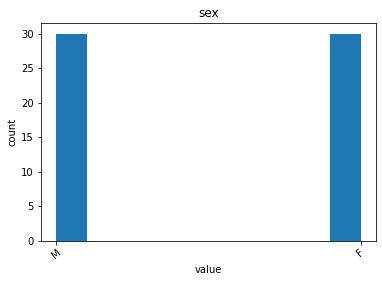

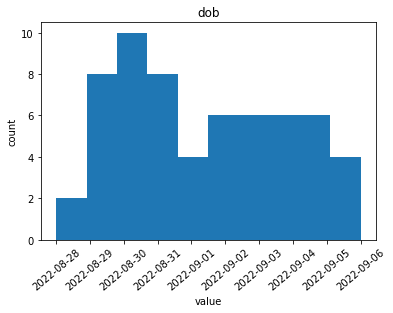

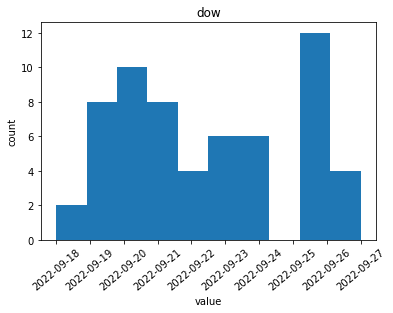

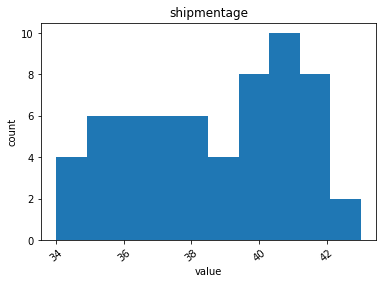

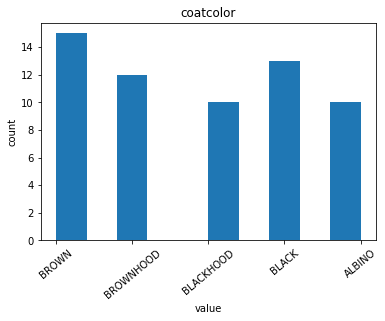

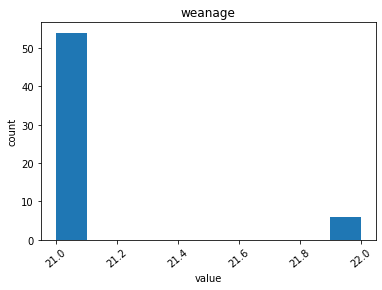

In [51]:
# data=df3
wfu_master=wfu
#check duplicate columns
checkDupCols(data)
#fix column names
data.columns = fixColumns(list(data.columns))
#RFIDs already in wfu
rfid_in_wfu(data)
#correct specific errors involving dates
data = date_error(data)
#add column headers to make uniform with wfu
new_columns(data)
#correct specific errors involving comments
data = comment_error(data)
#correct specific errors involving columns
data = column_error(data)
#Drop columns with all NA values
data = drop_na(data)
#column information
column_qc()
#rows with notable errors
data = error_rows(data)
#cohort information
cohorts(data)
#calculate pedigree related information
qc_pedigree(data)
#caluclate the range of birth dates
birth_range()
#calculate the range of wean dates
wean_range()
#qc coat color
coat_color(data)
#error fixing for rfids
error_rfids(data)
#find inccorrect rfids
# check_rfid()
#sibling count
data = siblings(data)
#plot relevant graphs
graph_columns()

In [82]:
## impliment any changes needed
data.columns
# data.drop(columns=['siblings', 'resolution'],inplace=True)
# data['comments']='Wrong RFIDS convention used by WFU'
data

,dames,sires,accessid,labanimalid,sex,rfid,dob,dow,shipmentdate,litternumber,littersize,coatcolor,earpunch,rack,shipmentbox,comments,shipmentage,weanage,cohort
0,78771_2,78700_1,IT601,80649_1,M,E21DCD383E,2022-08-28,2022-09-18,2022-10-10,9,7,BROWN,LT,B-F1,1,Wrong RFIDS convention used by WFU,43,21,C17
1,78712_2,78795_1,IT602,80680_3,M,E21DCD3834,2022-08-29,2022-09-19,2022-10-10,4,7,BROWN,LMRM,B-F1,1,Wrong RFIDS convention used by WFU,42,21,C17
2,78688_2,78692_1,IT605,80650_1,M,E21DCD381C,2022-08-29,2022-09-19,2022-10-10,9,6,BROWNHOOD,LT,B-F2,1,Wrong RFIDS convention used by WFU,42,21,C17
3,78770_1,78828_1,IT606,80647_1,M,E21DCD3811,2022-08-29,2022-09-19,2022-10-10,10,5,BLACKHOOD,RM,B-F2,1,Wrong RFIDS convention used by WFU,42,21,C17
4,78786_2,78796_1,IT609,80648_1,M,E21DCD37F3,2022-08-29,2022-09-19,2022-10-10,10,8,BROWNHOOD,LM,B-F3,1,Wrong RFIDS convention used by WFU,42,21,C17
5,78765_2,78699_1,IT610,80679_1,M,E21DCD3814,2022-08-30,2022-09-20,2022-10-10,10,9,BLACKHOOD,RT,B-F3,1,Wrong RFIDS convention used by WFU,41,21,C17
6,79133_2,78701_1,IT613,80661_1,M,E21DCD37FB,2022-08-30,2022-09-20,2022-10-10,5,10,BROWN,LM,B-F4,2,Wrong RFIDS convention used by WFU,41,21,C17
7,78709_2,78768_1,IT614,80684_1,M,E21DCD382E,2022-08-30,2022-09-20,2022-10-10,10,6,BLACKHOOD,RB,B-F4,2,Wrong RFIDS convention used by WFU,41,21,C17
8,78787_2,78710_1,IT617,80659_1,M,E21DCD3810,2022-08-30,2022-09-20,2022-10-10,8,7,BLACKHOOD,LT,B-F5,2,Wrong RFIDS convention used by WFU,41,21,C17
9,78827_2,78856_1,IT618,80660_1,M,E21DCD384C,2022-08-30,2022-09-20,2022-10-10,9,9,BROWN,RM,B-F5,2,Wrong RFIDS convention used by WFU,41,21,C17


In [262]:
# to fix time stamp issue
# data['dob']=data['dob'].astype(str)
# data['dow']=data['dow'].astype(str)
# data['shipmentdate']=data['shipmentdate'].astype(str)
# data.drop(columns=['siblings', 'resolution'],inplace=True)
data

,index,rfid,labanimalid,dames,sires,parentpair,cageloc,sex,dob,genotypingsent@10days,coatcolor,earpunch,comments,cohort,resolution,siblings
0,0,RATTACA_20220411_001,1,78768_2,78765_1,1552,C-F5,M,2022-04-01,2022/04/19,BLACKHOOD,LT,NA,C,NA,0.0
1,1,RATTACA_20220411_002,2,79074_2,78689_1,1547,B-J3,M,2022-04-01,2022/04/19,BROWN,LT,NA,C,NA,0.0
2,2,RATTACA_20220411_003,3,78765_2,78699_1,1538,C-H8,M,2022-04-01,2022/04/19,BLACK,LT,NA,C,NA,0.0
3,3,RATTACA_20220411_004,4,78123_2,78077_1,1439,C-H1,M,2022-04-01,2022/04/19,BROWNHOOD,LT,NA,C,NA,0.0
4,4,RATTACA_20220411_005,5,78120_2,78105_1,1465B,A-C8,M,2022-04-01,2022/04/19,BLACKHOOD,LM,NA,C,NA,0.0
5,5,RATTACA_20220411_006,6,78111_2,78032_1,1450,A-E8,M,2022-04-01,2022/04/19,BROWN,LM,NA,C,NA,0.0
6,6,RATTACA_20220411_007,7,78086_2,78118_1,1403,A-J4,M,2022-04-01,2022/04/19,BLACK,LM,NA,C,NA,0.0
7,7,RATTACA_20220411_008,8,78785_2,78705_1,1540,C-D7,M,2022-04-02,2022/04/19,Black,LB,NA,C,NA,0.0
8,8,RATTACA_20220411_009,9,78775_2,78711_1,1559,C-B4,M,2022-04-02,2022/04/19,BLACKHOOD,LB,NA,C,NA,0.0
9,9,RATTACA_20220411_010,10,78043_2,78243_1,1410B,B-E4,M,2022-04-02,2022/04/19,BROWNHOOD,LM,NA,C,NA,0.0


In [84]:

def insertQuery(query, data):
    connection = psycopg2.connect(database = "PalmerLab_Datasets",
                                  user = "postgres",
                                  password = "palmerlab-amapostgres",
                                  host = "palmerlab-main-database-c2021-08-02.c6sgfwysomht.us-west-2.rds.amazonaws.com",
                                  port = '5432')
    cursor = connection.cursor()
    if "INSERT" in query:
        cols = ",".join([str(i) for i in data.columns.tolist()])
        for i, row in data.iloc[0:1, :].iterrows():
            query = query + " (" + cols + ") VALUES (" + "%s,"*(len(row)-1) + "%s)"
            cursor.execute(query, tuple(row))
            print(list(row))
            connection.commit()
    else:
        return None
    if(connection):
        cursor.close()
        connection.close()
        return



# test=test.drop(columns=['cohort'])


# 9:21
project = "XXX"
query = "INSERT INTO " + project + "XXX"
data = data ## what does this mean 
data.index = range(data.shape[0])
print(list(data.columns))
for index, row in data.iterrows():
    print(index)
    print(list(row))
    insertQuery(query, data.iloc[index:index+1, :])
    


['dames', 'sires', 'accessid', 'labanimalid', 'sex', 'rfid', 'dob', 'dow', 'shipmentdate', 'litternumber', 'littersize', 'coatcolor', 'earpunch', 'rack', 'shipmentbox', 'comments', 'shipmentage', 'weanage', 'cohort']
0
['78771_2', '78700_1', 'IT601', '80649_1', 'M', 'E21DCD383E', '2022-08-28', '2022-09-18', '2022-10-10', 9, 7, 'BROWN', 'LT', 'B-F1', 1, 'Wrong RFIDS convention used by WFU', 43, 21, 'C17']
['78771_2', '78700_1', 'IT601', '80649_1', 'M', 'E21DCD383E', '2022-08-28', '2022-09-18', '2022-10-10', 9, 7, 'BROWN', 'LT', 'B-F1', 1, 'Wrong RFIDS convention used by WFU', 43, 21, 'C17']
1
['78712_2', '78795_1', 'IT602', '80680_3', 'M', 'E21DCD3834', '2022-08-29', '2022-09-19', '2022-10-10', 4, 7, 'BROWN', 'LMRM', 'B-F1', 1, 'Wrong RFIDS convention used by WFU', 42, 21, 'C17']
['78712_2', '78795_1', 'IT602', '80680_3', 'M', 'E21DCD3834', '2022-08-29', '2022-09-19', '2022-10-10', 4, 7, 'BROWN', 'LMRM', 'B-F1', 1, 'Wrong RFIDS convention used by WFU', 42, 21, 'C17']
2
['78688_2', '7869